<a href="https://colab.research.google.com/github/SinisterXI/CS-351L---AI-Lab-GitHub-Repository_2022428/blob/main/CS351_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the Required Libraries**

In [5]:
from google.colab import files
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from matplotlib.gridspec import GridSpec
from Crypto.Cipher import AES, DES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad
from scipy.stats import entropy
import time
import seaborn as sns
from PIL import Image
import ipywidgets as widgets
from scipy.stats import entropy as scipy_entropy
from collections import Counter


## **Encryption**

In [21]:
class VisualGeneticEncryption:
    def __init__(self, num_layers=3, population_size=20):
        self.num_layers = num_layers
        self.population_size = population_size
        self.mutation_rates = [0.05, 0.03, 0.02]
        self.best_transformations = []
        self.visualization_data = {
            'fitness_history': [],
            'diversity_history': [],
            'best_candidates': []
        }

    def encrypt(self, image_array):
        self.original_image = image_array
        encrypted_image = self.original_image.copy()
        plt.ion()

        for layer in range(self.num_layers):
            print(f"\nProcessing Layer {layer + 1}/{self.num_layers}")
            encrypted_image = self._encrypt_layer(encrypted_image, layer)
            self._plot_layer_results(layer)

        plt.ioff()
        return encrypted_image

    def _encrypt_layer(self, image, layer_index):
        height, width = image.shape
        population = self._initialize_image_population(image)

        self.visualization_data['fitness_history'] = []
        self.visualization_data['diversity_history'] = []
        self.visualization_data['best_candidates'] = []

        generations = 30 + (15 * layer_index)
        mutation_rate = self.mutation_rates[layer_index]

        for generation in range(generations):
            fitness_scores = [self._fitness_function(encrypted_img, image, layer_index)
                            for encrypted_img in population]

            self.visualization_data['fitness_history'].append(max(fitness_scores))
            diversity = self._calculate_image_diversity(population)
            self.visualization_data['diversity_history'].append(diversity)

            best_idx = fitness_scores.index(max(fitness_scores))
            self.visualization_data['best_candidates'].append(population[best_idx])

            if generation % 5 == 0:
                self._plot_generation_progress(generation, generations, layer_index)

            parents = self._select_image_parents(population, fitness_scores)
            new_population = self._crossover_images(parents)
            population = [self._mutate_image(img, mutation_rate) for img in new_population]

        best_image = population[fitness_scores.index(max(fitness_scores))]
        self.best_transformations.append(best_image - image)
        return best_image

    def _initialize_image_population(self, base_image):
        population = []
        for _ in range(self.population_size):
            noise = np.random.normal(0, 25, base_image.shape).astype(np.uint8)
            transformed = cv2.add(base_image, noise)

            if random.random() < 0.3:
                rows, cols = base_image.shape
                M = cv2.getRotationMatrix2D((cols/2, rows/2), random.uniform(-5, 5), 1)
                transformed = cv2.warpAffine(transformed, M, (cols, rows))

            population.append(transformed)
        return population

    def _fitness_function(self, encrypted_img, original_img, layer_index):
        if layer_index == 0:
            return np.mean(np.abs(encrypted_img - original_img))
        elif layer_index == 1:
            hist = cv2.calcHist([encrypted_img], [0], None, [256], [0, 256])
            return -np.sum(hist * np.log2(hist + 1e-10))
        else:
            gradient = np.gradient(encrypted_img)
            return np.mean(np.abs(gradient))

    def _select_image_parents(self, population, fitness_scores):
        selected = []
        tournament_size = 3
        for _ in range(self.population_size):
            tournament = random.sample(range(self.population_size), tournament_size)
            winner = max(tournament, key=lambda i: fitness_scores[i])
            selected.append(population[winner].copy())
        return selected

    def _crossover_images(self, parents):
        new_population = []
        for i in range(0, self.population_size, 2):
            parent1, parent2 = parents[i], parents[i+1]
            split = random.randint(0, parent1.shape[1])

            child1 = parent1.copy()
            child2 = parent2.copy()

            child1[:, split:] = parent2[:, split:]
            child2[:, split:] = parent1[:, split:]

            new_population.extend([child1, child2])
        return new_population

    def _mutate_image(self, image, mutation_rate):
      mutated = image.copy()
      mask = np.random.random(image.shape) < mutation_rate
      mutated[mask] = np.random.randint(0, 256, size=np.sum(mask))

      if random.random() < 0.1:
        rows, cols = image.shape
        if random.random() < 0.5:
            M = cv2.getRotationMatrix2D((cols/2, rows/2), random.uniform(-2, 2), 1)
            mutated = cv2.warpAffine(mutated, M, (cols, rows))
        else:
            # Perspective transform with properly shaped points
            offset = 5
            src_pts = np.array([[0,0], [cols-1,0], [0,rows-1], [cols-1,rows-1]], dtype=np.float32)
            dst_pts = src_pts + np.random.uniform(-offset, offset, size=src_pts.shape).astype(np.float32)
            M = cv2.getPerspectiveTransform(src_pts.reshape(-1, 1, 2), dst_pts.reshape(-1, 1, 2))
            mutated = cv2.warpPerspective(mutated, M, (cols, rows))

      return mutated

    def _calculate_image_diversity(self, population):
        if not population:
            return 0
        avg_image = np.mean(population, axis=0)
        distances = [np.mean(np.abs(img - avg_image)) for img in population]
        return np.mean(distances)

    def _plot_generation_progress(self, generation, total_generations, layer):
        clear_output(wait=True)

        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 3, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(self.visualization_data['fitness_history'])
        ax1.set_title('Fitness Progress')

        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(self.visualization_data['diversity_history'])
        ax2.set_title('Population Diversity')

        ax3 = fig.add_subplot(gs[0, 2])
        if self.visualization_data['best_candidates']:
            ax3.imshow(self.visualization_data['best_candidates'][-1], cmap='gray')
        ax3.set_title(f'Best Candidate\nGen {generation}/{total_generations}')
        ax3.axis('off')

        ax4 = fig.add_subplot(gs[1, 0])
        ax4.imshow(self.original_image, cmap='gray')
        ax4.set_title('Original Image')
        ax4.axis('off')

        plt.tight_layout()
        display(fig)
        plt.close()

    def _plot_layer_results(self, layer):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.visualization_data['fitness_history'])
        plt.title(f'Layer {layer + 1} Fitness History')

        plt.subplot(132)
        plt.plot(self.visualization_data['diversity_history'])
        plt.title('Population Diversity')

        plt.subplot(133)
        if self.visualization_data['best_candidates']:
            plt.imshow(self.visualization_data['best_candidates'][-1], cmap='gray')
        plt.title('Final Layer Result')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def decrypt(self, encrypted_image):
        decrypted = encrypted_image.copy()
        for transform in reversed(self.best_transformations):
            decrypted = cv2.subtract(decrypted, transform)
        return decrypted

## **Comparing the Encryption with AES and DES**

In [22]:
class EncryptionComparison:
    def __init__(self):
        self.metrics = {}

    def pad_image(self, image):
        block_size = AES.block_size
        height, width = image.shape
        padded_data = pad(image.tobytes(), block_size)
        padded_size = len(padded_data)

        new_width = width
        new_height = padded_size // width
        if padded_size % width != 0:
            new_height += 1
            new_width = ((padded_size + new_height - 1) // new_height)

        new_height = ((new_height + block_size - 1) // block_size) * block_size
        new_width = ((new_width + block_size - 1) // block_size) * block_size

        padded_image = np.zeros((new_height, new_width), dtype=np.uint8)
        padded_image[:height, :width] = image
        return pad(padded_image.tobytes(), block_size), new_height, new_width

    def encrypt_AES(self, image):
        key = get_random_bytes(16)
        cipher = AES.new(key, AES.MODE_ECB)
        padded, new_height, new_width = self.pad_image(image)
        start_time = time.time()
        encrypted = cipher.encrypt(padded)
        end_time = time.time()

        encrypted_img = np.frombuffer(encrypted, dtype=np.uint8)
        encrypted_img = encrypted_img[:new_height*new_width].reshape((new_height, new_width))
        return encrypted_img, end_time - start_time, key

    def encrypt_DES(self, image):
        key = get_random_bytes(8)
        cipher = DES.new(key, DES.MODE_ECB)
        padded, new_height, new_width = self.pad_image(image)
        start_time = time.time()
        encrypted = cipher.encrypt(padded)
        end_time = time.time()

        encrypted_img = np.frombuffer(encrypted, dtype=np.uint8)
        encrypted_img = encrypted_img[:new_height*new_width].reshape((new_height, new_width))
        return encrypted_img, end_time - start_time, key

    def entropy(self, signal):
        """Calculate Shannon entropy of a signal."""
        # Get probability of each value in the signal
        value_counts = Counter(signal)
        probs = np.array([count/len(signal) for count in value_counts.values()])
        return scipy_entropy(probs, base=2)

    def analyze_encryption(self, original_image, encrypted_image, algorithm_name, time_taken):
        if len(original_image.shape) == 3 and len(encrypted_image.shape) == 2:
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        elif len(original_image.shape) == 2 and len(encrypted_image.shape) == 3:
            encrypted_image = cv2.cvtColor(encrypted_image, cv2.COLOR_BGR2GRAY)

        if len(encrypted_image.shape) == 1:
            encrypted_image = encrypted_image.reshape(original_image.shape)

        if original_image.shape != encrypted_image.shape:
            encrypted_image = cv2.resize(encrypted_image, (original_image.shape[1], original_image.shape[0]))

        cmap = 'gray' if len(original_image.shape) == 2 else None

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original_image, cmap=cmap)
        axes[0].set_title(f"Original Image - {algorithm_name}")
        axes[1].imshow(encrypted_image, cmap=cmap)
        axes[1].set_title(f"Encrypted Image - {algorithm_name}")
        plt.show()

        original_flat = original_image.flatten()
        encrypted_flat = encrypted_image.flatten()

        metrics = {}
        metrics['correlation'] = np.corrcoef(original_flat, encrypted_flat)[0, 1]
        metrics['entropy'] = entropy(encrypted_flat)
        diff = original_image != encrypted_image
        metrics['npcr'] = np.sum(diff) * 100 / diff.size
        metrics['time'] = time_taken

        self.metrics[algorithm_name] = metrics
        return metrics

def compare_encryptions(image):
    genetic_encryptor = VisualGeneticEncryption()
    comparison = EncryptionComparison()

    # Genetic Encryption
    start_time = time.time()
    genetic_encrypted = genetic_encryptor.encrypt(image)
    genetic_time = time.time() - start_time
    genetic_metrics = comparison.analyze_encryption(image, genetic_encrypted, "Genetic", genetic_time)

    # AES Encryption
    aes_encrypted, aes_time, aes_key = comparison.encrypt_AES(image)
    aes_metrics = comparison.analyze_encryption(image, aes_encrypted, "AES", aes_time)

    # DES Encryption
    des_encrypted, des_time, des_key = comparison.encrypt_DES(image)
    des_metrics = comparison.analyze_encryption(image, des_encrypted, "DES", des_time)

    return comparison.metrics, genetic_encrypted, aes_encrypted, des_encrypted

## **Calling all the functions**

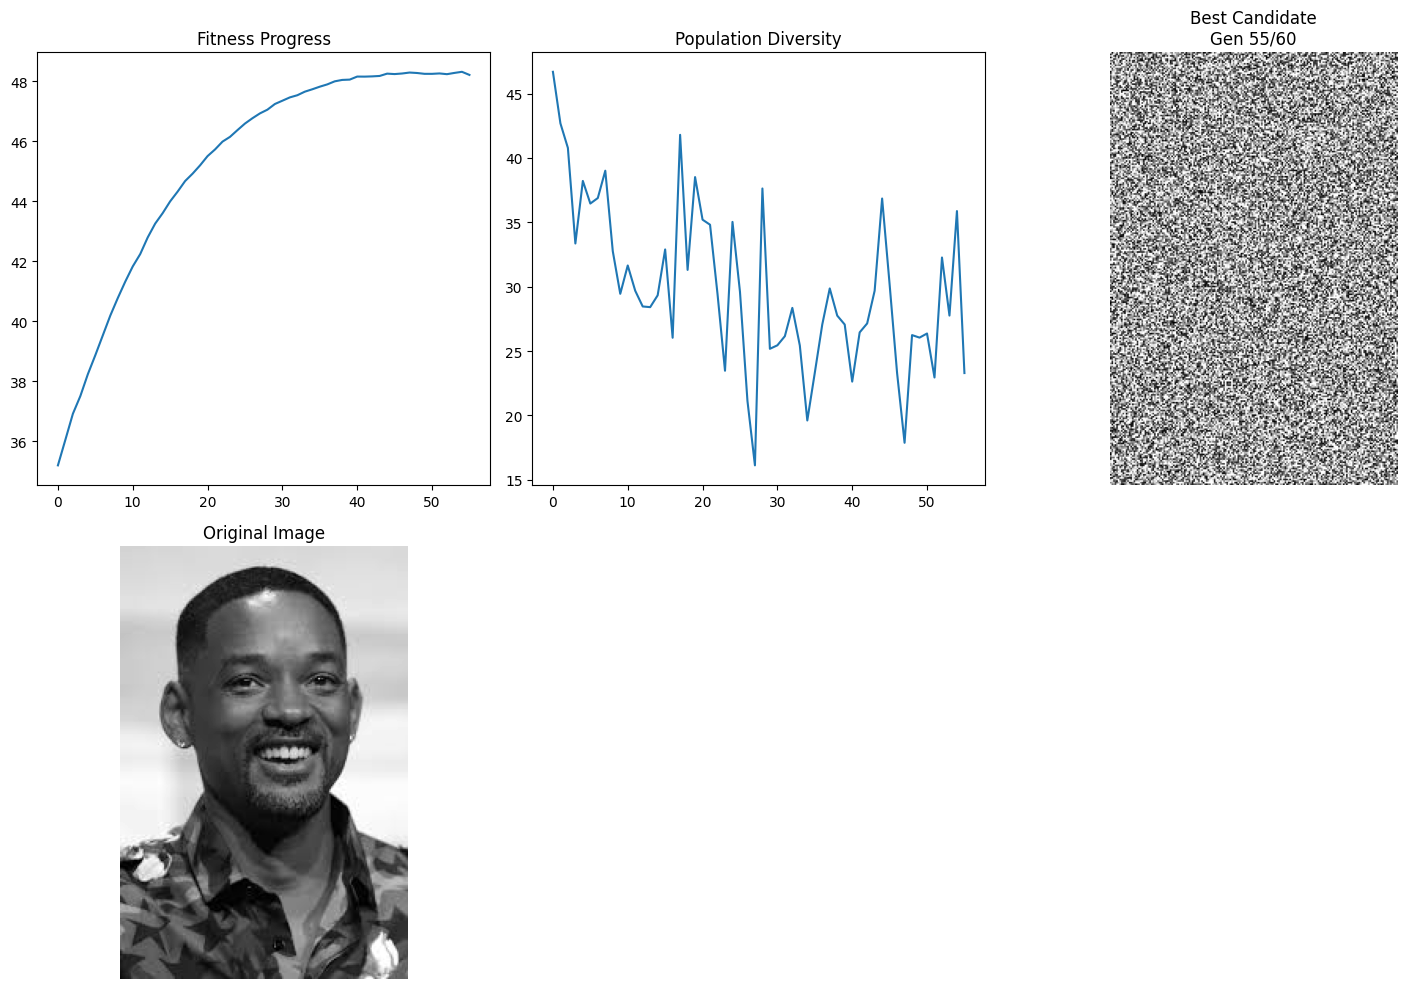

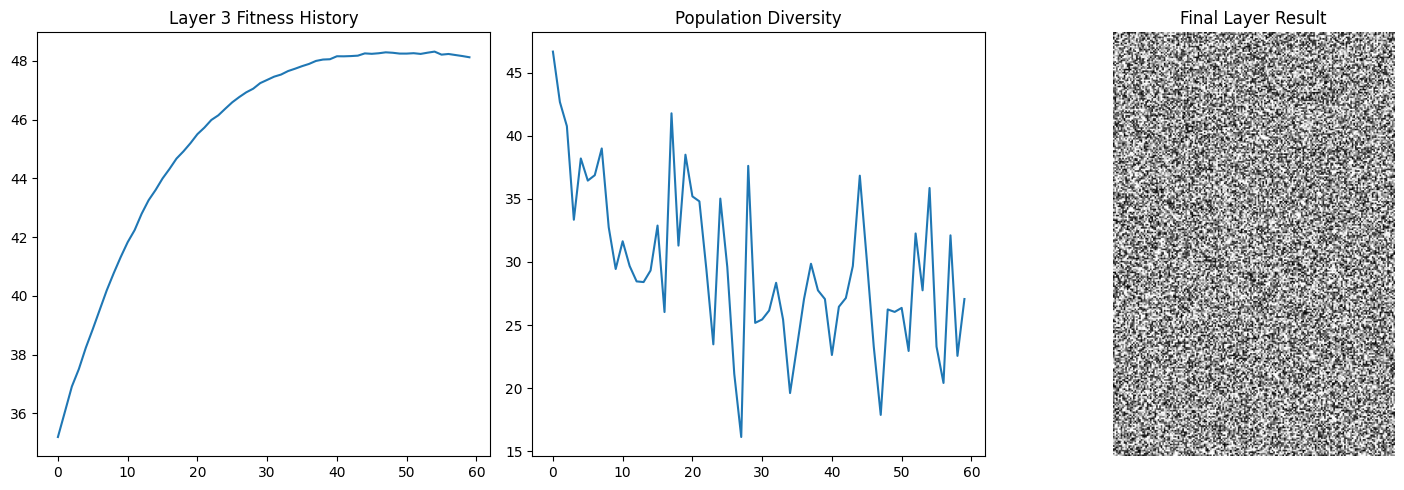

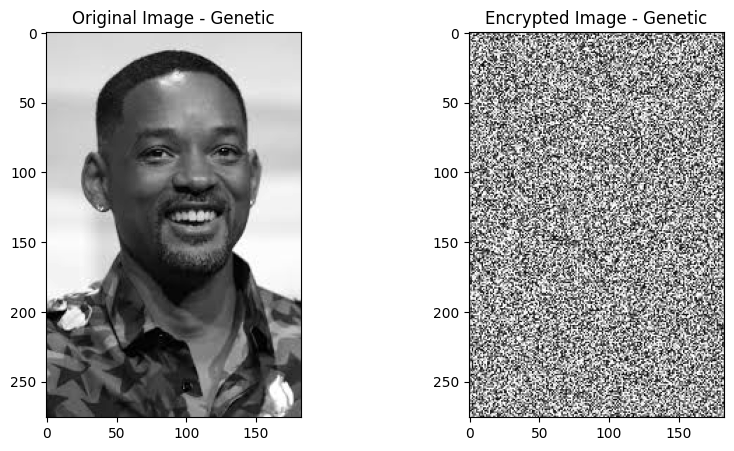

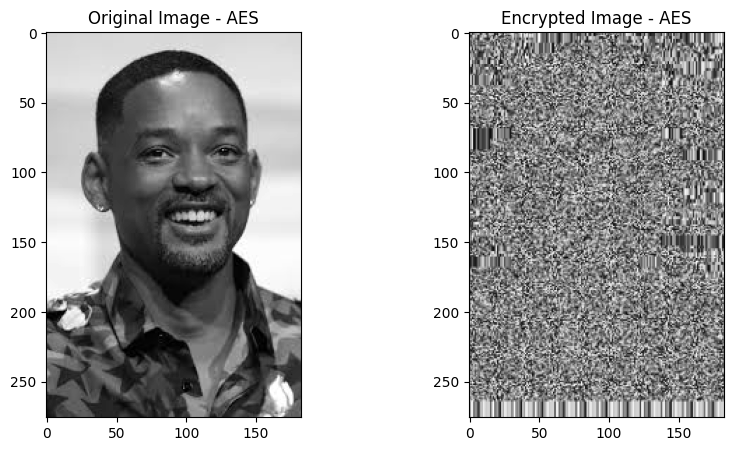

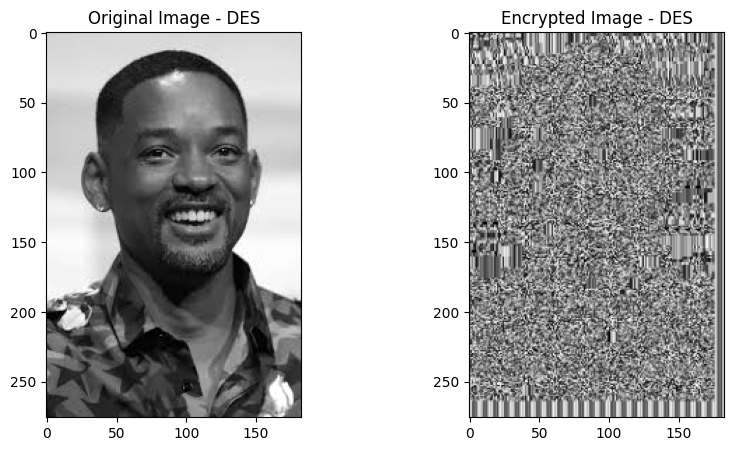


Encryption Metrics Comparison:

Genetic Encryption Metrics:
correlation: -0.001804589548128454
entropy: 10.649277871567085
npcr: 99.6376811594203
time: 29.101881504058838

AES Encryption Metrics:
correlation: -0.028625738483211007
entropy: 10.743181280021018
npcr: 99.66341965629208
time: 0.0017805099487304688

DES Encryption Metrics:
correlation: 0.028712909944277828
entropy: 10.745732706249543
npcr: 99.63174150629604
time: 0.0009431838989257812


In [23]:
def main():
    print("Click the button below to upload an image file:")
    upload_button = widgets.FileUpload(accept='image/*', multiple=False)

    def handle_upload(change):
        for filename in upload_button.value:
            file_bytes = upload_button.value[filename]['content']
            nparr = np.frombuffer(file_bytes, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

            metrics, genetic, aes, des = compare_encryptions(img)

            print("\nEncryption Metrics Comparison:")
            for algo, data in metrics.items():
                print(f"\n{algo} Encryption Metrics:")
                for key, value in data.items():
                    print(f"{key}: {value}")

    upload_button.observe(handle_upload, names='value')
    display(upload_button)



if __name__ == "__main__":
    main()